# Optimal operation of gas storage

Find optimal operation of gas storage (maximize profit) for next year with the following setting:
1. capacity of gas storage is 16000 MWh
1. initial state of gas storage is 0 MWh
1. *injection rate* (maximal) is 35 MWh of gas per hour
1. *withdrawal rate* (maximal) is 52 MWh of gas per hour
1. *injection fee* is 1.05 EUR per MWh of gas
1. *withdrawal fee* is 0.9 EUR per MWh of gas

Furthermore, we assume:
1. that prices of a gas on the period of interest is known in advance and given to us,
1. for each day, we assume constant operation of gas storage

In [2]:
import os
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
capacity = 16000
initial = 0
ir = 35 * 24 # per day
wr = 52 * 24 # per day
fee_in = 1.05
fee_out = 0.9
price_curve = np.load(os.path.join("data", "price_curve.npy"))
n = len(price_curve)

In [4]:
inflow = cp.Variable(n, name="inflow", nonneg=True)
outflow = cp.Variable(n, name="outflow", nonneg=True)
inventory = cp.Variable(n, name="inventory", nonneg=True)
flow = inflow - outflow

In [5]:
constraints = [
    inflow <= ir,
    outflow <= wr,
    inventory <= capacity,
    cp.cumsum(flow) == initial + inventory,
]
cashflow = (cp.multiply(outflow, price_curve - fee_out)
            - cp.multiply(inflow, price_curve + fee_in))
profit = cp.sum(cashflow)

In [6]:
objective = cp.Maximize(profit)
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS, verbose=True)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 01 10:57:46 AM: Your problem has 1095 variables, 4 constraints, and 0 parameters.
(CVXPY) Dec 01 10:57:46 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 01 10:57:46 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 01 10:57:46 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 01 10:57:46 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 01 10:57:46 AM: Compiling problem (target solver=ECOS).
(C

41169.865183559246

<Figure size 800x2000 with 0 Axes>

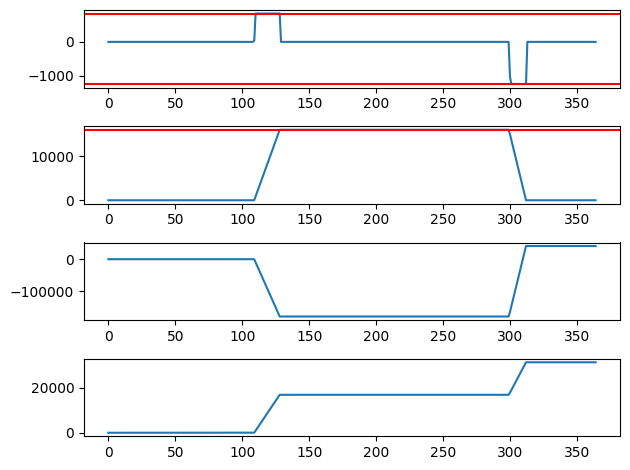

In [7]:
plt.figure(figsize=(8, 20))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4)
ax1.plot(flow.value)
ax1.axhline(ir, color='red', label="injection rate")
ax1.axhline(-wr, color='red', label="withdrawal")

ax2.plot(inventory.value)
ax2.axhline(capacity, color='red', label='storage capacity')

ax3.plot(np.cumsum(cashflow.value))
ax4.plot(np.cumsum(inflow.value * fee_in + outflow.value * fee_out))

plt.tight_layout()